In [6]:
!pip install joblib

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import joblib

In [21]:
import pandas as pd
from scipy.io import arff
import io

file_name = "nsl_kdd.csv"

# Read the original file content
with open(file_name, 'r') as f:
    content = f.read()

# Heuristic fix: Address potential parsing issues with nominal values in ARFF header.
# The error suggests scipy.io.arff might be adding leading spaces to nominal values internally.
# This attempts to clean up any spaces after commas or opening braces in nominal attribute definitions.
fixed_content = content.replace("', '", "','") # Remove space after comma in nominal list
fixed_content = fixed_content.replace("{' ", "{'") # Remove space after opening brace if present

# Load the modified content using arff.loadarff
data, meta = arff.loadarff(io.StringIO(fixed_content))

# Create DataFrame explicitly to ensure byte string columns are properly decoded
decoded_data = {}
for name in data.dtype.names:
    # If the column is a byte string type (S for string_),
    # decode it to a regular Python string type
    if data[name].dtype.kind == 'S':
        decoded_data[name] = data[name].astype('U')
    else:
        decoded_data[name] = data[name]

df = pd.DataFrame(decoded_data)

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,10.0,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2.0,tcp,ftp_data,SF,12983.0,0.0,0,0.0,0.0,0.0,...,86.0,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0.0,icmp,eco_i,SF,20.0,0.0,0,0.0,0.0,0.0,...,57.0,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1.0,tcp,telnet,RSTO,0.0,15.0,0,0.0,0.0,0.0,...,86.0,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


In [22]:
df.info()
df['class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  float64
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  float64
 5   dst_bytes                    22544 non-null  float64
 6   land                         22544 non-null  object 
 7   wrong_fragment               22544 non-null  float64
 8   urgent                       22544 non-null  float64
 9   hot                          22544 non-null  float64
 10  num_failed_logins            22544 non-null  float64
 11  logged_in                    22544 non-null  object 
 12  num_compromised              22544 non-null  float64
 13  root_shell      

,count
class,
anomaly,12833
normal,9711


In [25]:
df = df.drop_duplicates().dropna()
df['label'] = df['class'].apply(lambda x: 0 if x == 'normal' else 1)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,label
0,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly,1
1,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly,1
2,2.0,tcp,ftp_data,SF,12983.0,0.0,0,0.0,0.0,0.0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,0
3,0.0,icmp,eco_i,SF,20.0,0.0,0,0.0,0.0,0.0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly,1
4,1.0,tcp,telnet,RSTO,0.0,15.0,0,0.0,0.0,0.0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly,1


In [27]:
X = df.drop(columns=['label'])
y = df['label']
cat_cols = [col for col in X.columns if X[col].dtype == object]
num_cols = [col for col in X.columns if col not in cat_cols]
len(cat_cols), len(num_cols)

(8, 34)

In [28]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
X_processed = preprocessor.fit_transform(X)
X_processed.shape

(22541, 122)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((18032, 122), (4509, 122))

In [32]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1943
           1       1.00      1.00      1.00      2566

    accuracy                           1.00      4509
   macro avg       1.00      1.00      1.00      4509
weighted avg       1.00      1.00      1.00      4509



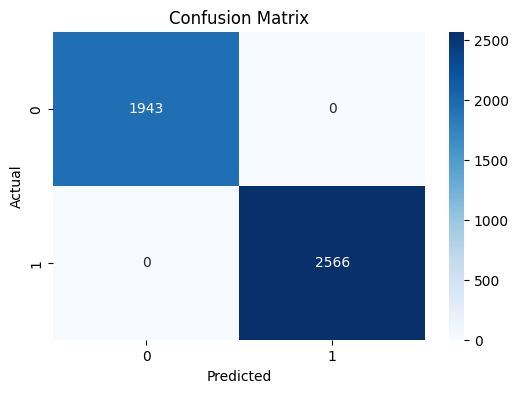

In [33]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [37]:
joblib.dump(model, "best_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
print("Model & Preprocessor saved successfully!")

Model & Preprocessor saved successfully!


In [35]:
sample = X.iloc[[0]]
processed_sample = preprocessor.transform(sample)
prediction = model.predict(processed_sample)
print("Prediction for first row:", prediction)

Prediction for first row: [1]


In [36]:
import json
metrics = classification_report(y_test, preds, output_dict=True)
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)
print("metrics.json saved!")

metrics.json saved!
